## Binary Bank Competition - Kaggle


### Jupyter Notebook in VS Code

From directory with virtual environment in it, use this terminal command to use Jupyter Notebook in VS Code:

jupyter notebook --NotebookApp.allow_origin='*' --NotebookApp.ip='0.0.0.0'

### Select Python Interpreter

Open Command Palette as follows: Ctrl+Shift+P

Then select from VS Code Command Palette: "Python: Select Interpreter" and choose the same Python interpreter that you used to install Jupyter.

If server not shown, enter server manually as follows: 
http://localhost:8888

Reminder:  pw: ""

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from stepbystep_v0 import StepByStep

# Binary Classification Problem based on Bank Customer Marketing Call Data

## Data Loading

In [9]:
# Import data from .csv file
raw_test_data = pd.read_csv('binary_bank_comp/dataset/test.csv')

# Display the first few rows of the dataset
print(raw_test_data[:5])

       id  age            job  marital  education default  balance housing  \
0  750000   32    blue-collar  married  secondary      no     1397     yes   
1  750001   44     management  married   tertiary      no       23     yes   
2  750002   36  self-employed  married    primary      no       46     yes   
3  750003   58    blue-collar  married  secondary      no    -1380     yes   
4  750004   28     technician   single  secondary      no     1950     yes   

  loan   contact  day month  duration  campaign  pdays  previous poutcome  
0   no   unknown   21   may       224         1     -1         0  unknown  
1   no  cellular    3   apr       586         2     -1         0  unknown  
2  yes  cellular   13   may       111         2     -1         0  unknown  
3  yes   unknown   29   may       125         1     -1         0  unknown  
4   no  cellular   22   jul       181         1     -1         0  unknown  


## Remove and save id column

In [10]:
# Remove and save id column
id_column = raw_test_data['id']
raw_test_data.drop(columns=['id'], inplace=True)
id_column

0         750000
1         750001
2         750002
3         750003
4         750004
           ...  
249995    999995
249996    999996
249997    999997
249998    999998
249999    999999
Name: id, Length: 250000, dtype: int64

## Data Cleaning

In [11]:
# Clean the dataset

# Identify numerical columns (excluding the target and any non-feature columns)
X_test_num_cols = raw_test_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical columns
X_test_categorical_cols = raw_test_data.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert categorical features to numerical using one-hot encoding using 1s and 0s
X_test = pd.get_dummies(raw_test_data, columns=X_test_categorical_cols, drop_first=False).astype(int)

# Standardize numerical features from 0 to 1
X_test[X_test_num_cols] = X_test[X_test_num_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Show the cleaned dataset
print(X_test.head())

        age   balance       day  duration  campaign  pdays  previous  \
0  0.181818  0.088383  0.666667  0.044964  0.000000    0.0       0.0   
1  0.337662  0.075486  0.066667  0.118616  0.017544    0.0       0.0   
2  0.233766  0.075702  0.400000  0.021974  0.017544    0.0       0.0   
3  0.519481  0.062317  0.933333  0.024822  0.000000    0.0       0.0   
4  0.129870  0.093574  0.700000  0.036216  0.000000    0.0       0.0   

   job_admin.  job_blue-collar  job_entrepreneur  ...  month_jun  month_mar  \
0           0                1                 0  ...          0          0   
1           0                0                 0  ...          0          0   
2           0                0                 0  ...          0          0   
3           0                1                 0  ...          0          0   
4           0                0                 0  ...          0          0   

   month_may  month_nov  month_oct  month_sep  poutcome_failure  \
0          1          0  

## Data Preparation

In [12]:
torch.manual_seed(13)

# Convert pandas DataFrames to Numpy arrays
X_test = X_test.to_numpy()

# Builds tensors from numpy arrays
x_test_tensor = torch.as_tensor(X_test).float()

# Builds dataset containing ALL data points
test_dataset = TensorDataset(x_test_tensor)

# Builds a loader of each set
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=True)

## Model

$$
\Large
y = b + w_1x_1 + w_2x_2 + ... + w_nx_n + \epsilon
$$

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 + ... + w_nx_n \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 + ... + w_nx_n < 0
\end{cases}
$$

### Logits

$$
\Large
z = b + w_1x_1 + w_2x_2 + ... + w_nx_n
$$

### Probabilities

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

### From Logits to Probabilities

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 + ... + w_nx_n = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2 + ... + w_nx_n} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

### Logistic Regression

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2 + ... + w_nx_n) = \frac{1}{1+e^{-(b+w_1x_1+w_2x_2 + ... + w_nx_n)}}      
$$

### A Note on Notation (for reference)

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

## Loss

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

## Model Configuration

In [47]:
# Sets learning rate - "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
feature_cnt = X_test.shape[1]
print("Number of features:", feature_cnt)
model = nn.Sequential()
model.add_module('linear0', nn.Linear(feature_cnt, 10))
model.add_module('activation0', nn.ReLU())
model.add_module('linear2', nn.Linear(10, 3))
model.add_module('activation2', nn.ReLU())
model.add_module('output', nn.Linear(3, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

Number of features: 51


## Model Definition

In [48]:
sbs = StepByStep(model, loss_fn, optimizer)
# Note: model is set to eval model in predict method
sbs.set_loaders(test_loader)

In [49]:
# Load model
sbs.load_checkpoint('binary_bank_comp/checkpoint_sgd_3layer_lr005_200.pth')

$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2 + ... + w_nx_n
\\
\end{array}
$$

#### Making Predictions (Logits)

In [50]:
predictions = sbs.predict(x_test_tensor)
predictions

array([[-6.765314 ],
       [-1.0316782],
       [-7.4149537],
       ...,
       [ 1.3175184],
       [-7.379964 ],
       [-1.478702 ]], shape=(250000, 1), dtype=float32)

#### Making Predictions (Probabilities)

In [51]:
# Convert predictions to probabilities using the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probabilities = sigmoid(predictions)  # Use torch's built-in sigmoid for numerical stabilit
probabilities

array([[1.1517572e-03],
       [2.6275888e-01],
       [6.0181785e-04],
       ...,
       [7.8876853e-01],
       [6.2323478e-04],
       [1.8562356e-01]], shape=(250000, 1), dtype=float32)

#### Making Predictions (Classes)

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

In [52]:
classes = (predictions >= 0).astype(int)

# Count positive predictions
positive_count = (classes == 1).sum()

output_classes = classes.astype(int).flatten()
output_probabilities = probabilities.astype(float).flatten()

# Get current date and time as a string, e.g., '2025-08-13_15-30-45'
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Output index ids and classes to .csv file
classes_df = pd.DataFrame({'id': id_column, 'class': output_classes})
classes_filename = f'binary_bank_comp/results/predicted_classes_{timestamp}.csv'
classes_df.to_csv(classes_filename, index=False)

# Output index ids and probabilities to .csv file
probabilities_df = pd.DataFrame({'id': id_column, 'y': output_probabilities})
probabilities_filename = f'binary_bank_comp/results/predicted_probabilities_{timestamp}.csv'
probabilities_df.to_csv(probabilities_filename, index=False)

print(id_column)
print(output_classes)
print(output_probabilities)
print()
print(positive_count)

0         750000
1         750001
2         750002
3         750003
4         750004
           ...  
249995    999995
249996    999996
249997    999997
249998    999998
249999    999999
Name: id, Length: 250000, dtype: int64
[0 0 0 ... 1 0 0]
[1.15175720e-03 2.62758881e-01 6.01817854e-04 ... 7.88768530e-01
 6.23234781e-04 1.85623556e-01]

25374


## Determine confusion matrix

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (classes > 0).float()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'classes' is not defined

In [34]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50625x2 and 51x1)

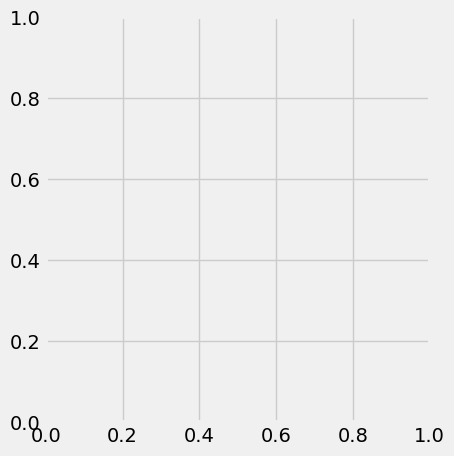

In [36]:
def probability_line(ax, y, probs, threshold, shift=0.0, annot=False, colors=None):
    if colors is None:
        colors = ['r', 'b']
    ax.grid(False)
    ax.set_ylim([-.1, .1])
    ax.axes.get_yaxis().set_visible(False)
    ax.plot([0, 1], [0, 0], linewidth=2, c='k', zorder=1)
    ax.plot([0, 0], [-.1, .1], c='k', zorder=1)
    ax.plot([1, 1], [-.1, .1], c='k', zorder=1)

    tn = (y == 0) & (probs < threshold)
    fn = (y == 0) & (probs >= threshold)
    tp = (y == 1) & (probs >= threshold)
    fp = (y == 1) & (probs < threshold)

    ax.plot([threshold, threshold], [-.1, .1], c='k', zorder=1, linestyle='--')
    ax.scatter(probs[tn], np.zeros(tn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    ax.scatter(probs[fn], np.zeros(fn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[1], linewidth=3)

    ax.scatter(probs[tp], np.zeros(tp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probs[fp], np.zeros(fp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[0], linewidth=3)

    ax.set_xlabel(r'$\sigma(z) = P(y=1)$')
    ax.set_title('Threshold = {}'.format(threshold))

    if annot:
        ax.annotate('TN', xy=(.20, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('FN', xy=(.20, -.08), c='k', weight='bold', fontsize=20)
        ax.annotate('FP', xy=(.70, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('TP', xy=(.70, -.08), c='k', weight='bold', fontsize=20)
    return ax

def probability_contour(ax, model, device, X, y, threshold, cm=None, cm_bright=None):
    if cm is None:
        cm = plt.cm.RdBu
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    h = .02  # step size in the mesh

    x_min, x_max = -2.25, 2.25
    y_min, y_max = -2.25, 2.25

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    logits = logits.detach().cpu().numpy().reshape(xx.shape)

    yhat = sigmoid(logits)

    ax.contour(xx, yy, yhat, levels=[threshold], cmap="Greys", vmin=0, vmax=1)
    contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.8, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')
    ax.grid(False)

    ax_c = plt.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])
    return ax

def figure9(x, y, model, device, probabilities, threshold, shift=0.0, annot=False, cm=None, cm_bright=None):
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(3, 3)

    ax = fig.add_subplot(gs[:, 0])
    probability_contour(ax, model, device, x, y, threshold, cm, cm_bright)
    
    if cm_bright is None:
        colors = ['r', 'b']
    else:
        colors = cm_bright.colors

    ax = fig.add_subplot(gs[1, 1:])
    probability_line(ax, y, probabilities, threshold, shift, annot, colors)

    fig.tight_layout()
    return fig

fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

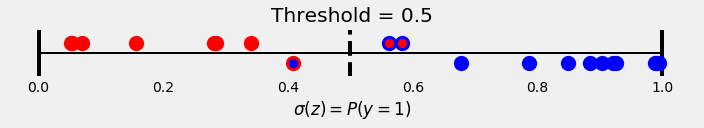

In [42]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

### Confusion Matrix

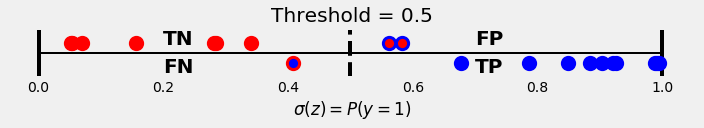

In [43]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [44]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

#### True and False Positives and Negatives

In [45]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

### Metrics

### True and False Positive Rates

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [46]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [47]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

### Precision and Recall

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [48]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [49]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

### Accuracy

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

## Trade-offs and Curves

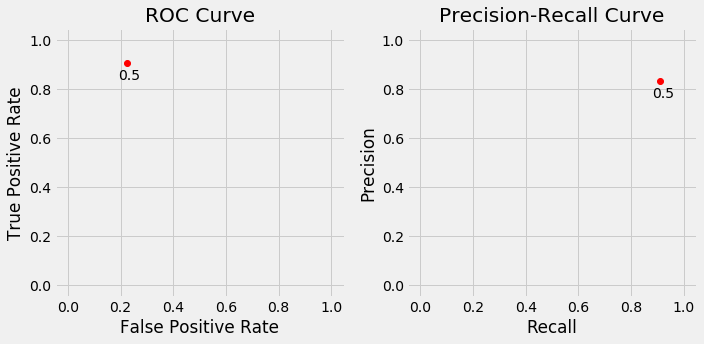

In [50]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

### Low Threshold

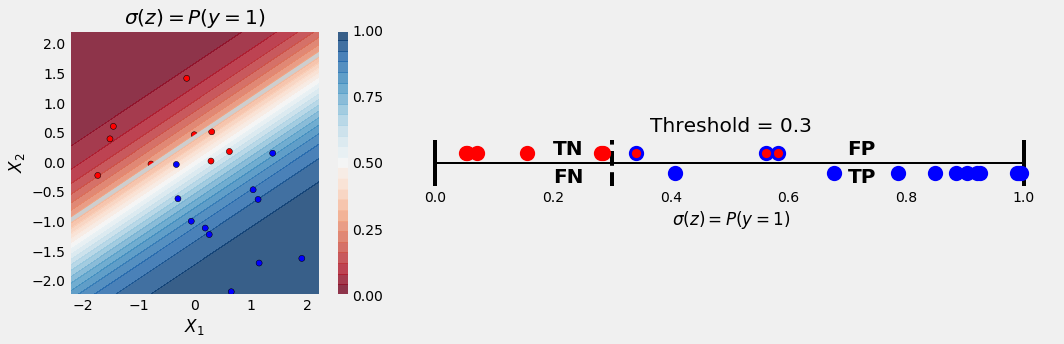

In [51]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

In [52]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

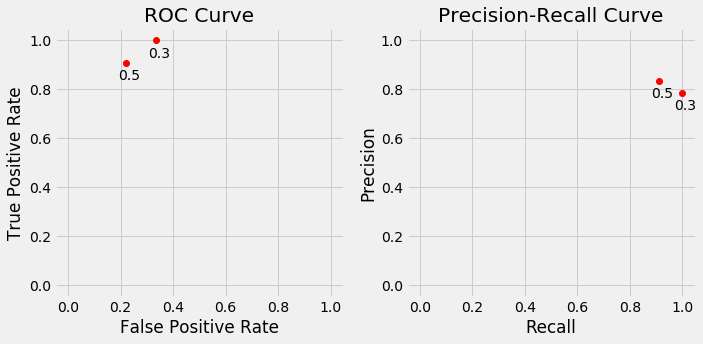

In [53]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

### High Threshold

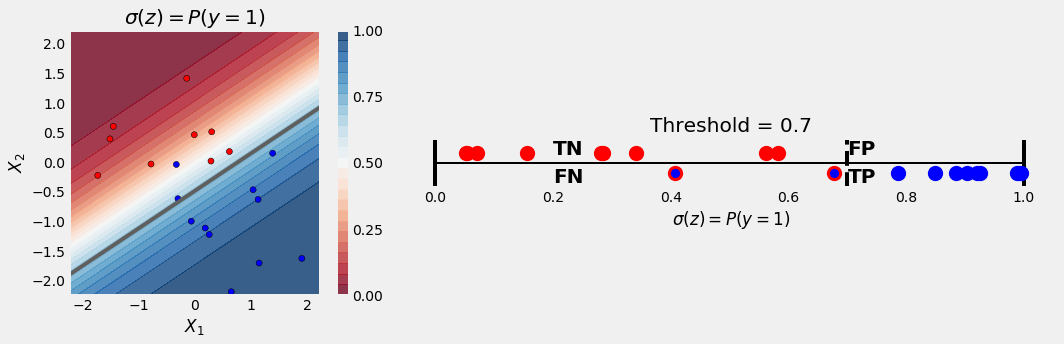

In [54]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

In [55]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

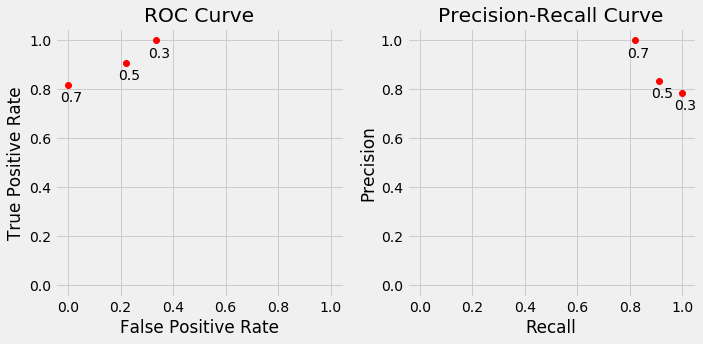

In [56]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

### ROC and PR Curves

In [57]:
threshs = np.linspace(0.,1,11)

/home/dvgodoy/projects/PyTorchStepByStep/plots/chapter3.py:49: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


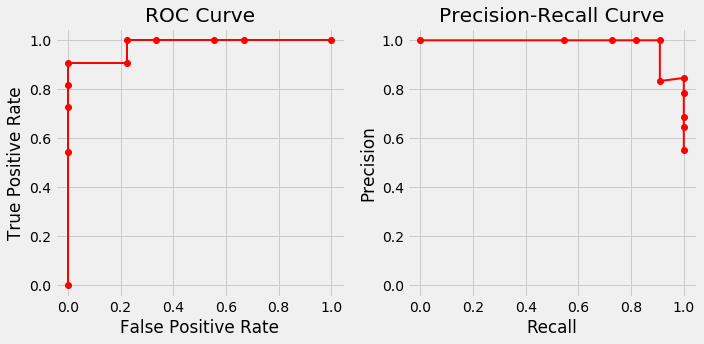

In [58]:
fig = figure17(y_val, probabilities_val, threshs)

In [59]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

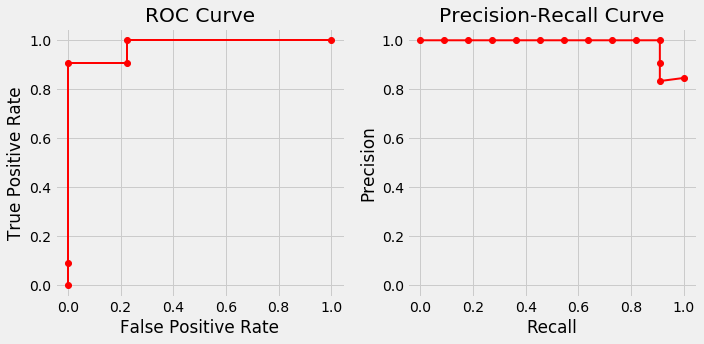

In [60]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

### The Precision Quirk

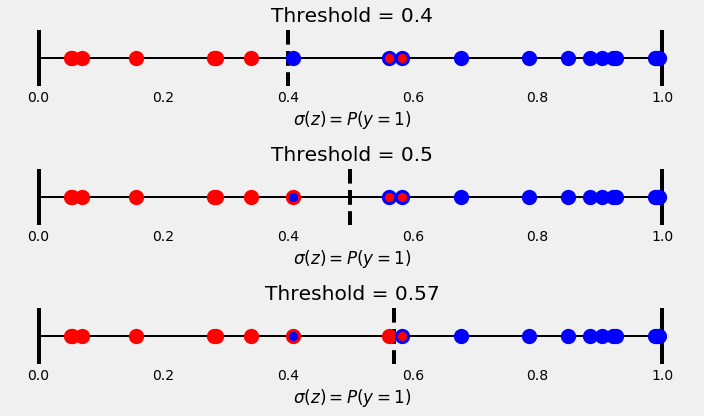

In [61]:
fig = figure19(y_val, probabilities_val)

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

### Best and Worst Curves

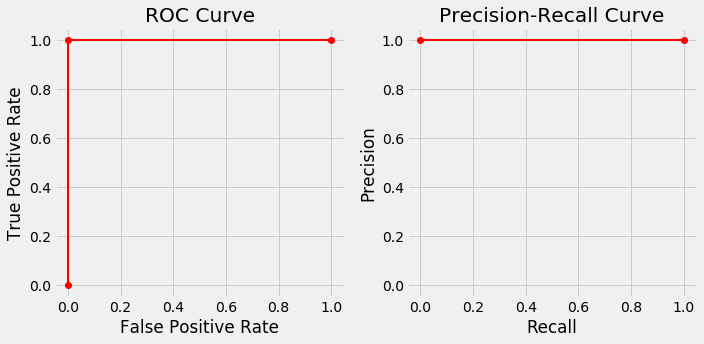

In [62]:
# Best
fig = figure20(y_val)

In [63]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [64]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

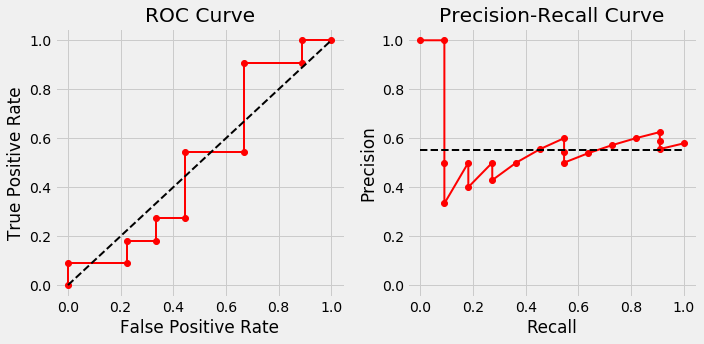

In [65]:
# Worst
fig = figure21(y_val, random_probs)

### Comparing Models

In [66]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [67]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


## Putting It All Together

In [68]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [69]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [70]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [71]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1822, -1.8684]], device='cuda:0')), ('linear.bias', tensor([-0.0587], device='cuda:0'))])


In [72]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])